## VIDEO TO FRAMES

Esta parte del código requiere la ruta donde se aloja el video, y genera los frames de los videos para el Método 1 y Método 2, no es necesario recortar los videos, o eliminar los frames (el código hace una limpieza  y no procesa los primeros y los últimos frames de cada video, es decir tomar solo los frames entre el 40% y el 80 % del video para evitar movimientos al principio o al final)

Solo cambiar la ruta del video

In [ ]:
import cv2
import os

# Folder containing videos to extract frames from
folder_path = r"D:\Tecnicas_observacionales\Seeing\videos\Videos_Bogota_diciembre"
output_base = os.path.join(folder_path, "frames")  # Base output directory

# Create base output folder if it doesn't exist
os.makedirs(output_base, exist_ok=True)

for filename in os.listdir(folder_path):
    if not filename.endswith(".avi"): #<-------------change to your video format
        continue

    video_name = os.path.splitext(filename)[0]  # Get video name without extension
    print(f"Processing: {video_name}")

    video_path = os.path.join(folder_path, filename)
    output_folder = os.path.join(output_base, video_name)  # Per-video output folder

    # Create video-specific output folder
    try:
        os.makedirs(output_folder, exist_ok=True)
    except OSError as e:
        print(f"Error creating directory {output_folder}: {e}")
        continue

    # Open video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error opening video file {video_path}")
        continue

    frame_count = 0
    print("\nStarting frame extraction...")

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Save frame as JPEG
        output_path = os.path.join(output_folder, f"frame{frame_count}.jpg")
        cv2.imwrite(output_path, frame)
        frame_count += 1

    print(f"\nFrame extraction completed")
    print(f"Total frames extracted: {frame_count}")
    print("--------------------------")

    # Release resources
    cap.release()

cv2.destroyAllWindows()

## Frames Analysis

Aquí se determina la distancia entre los spot de las estrellas del método 1 y el método 2. 

Se requiere insertar la ruta donde se guardaron los frames

Sarazin & Roddier (1990), definen la varianza en términos del movimiento total como:

$$
\sigma^{2} = 2B_{\alpha}(0,0) = 0.358 \left(\frac{\lambda}{r_0}\right)^{5/3} \left(\frac{\lambda}{D}\right)^{1/3}

$$

Donde $D$ es el diámetro de las aperturas 4.2 cm, $r_0$ es el parámetro de Fried y $\lambda$ es la longitud de onda, en este caso el visible , 0.5 $\mu$ m

Seeing :
$$
FWHM = \Delta \theta = 0.98 \lambda / r_0
$$

Corrección por video

Factor de recorte, 6000/1920 = 3.125
Por relación de frame del video con tamaño captura


Unidades radianes o unidades de angulo
Longitudinal o transversal




In [57]:
"""________________Distance_IMG______________
Program that builds the frequency histogram of the separation
between two spots (objects) in the DIMM."""

"""_________________Libraries________________________"""
import os
import glob
import re
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.spatial import distance as dist
from astropy.stats import mad_std
from astropy.coordinates import Angle
from astropy import units as u

"""__________________FUNCTIONS_______________________"""

def identify_stars_and_distance(image_path, thresh, plot=False):
    # Load image with grayscale filter
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    image[:50, :200] = 0  # Remove image border (first 50px in y and 200px in x)

    # Calculate standard deviation (background noise) of image without background
    median = np.median(image)

    image_median_subtracted = np.clip(image - median, 0, 255).astype(np.uint8)
    
    std = np.std(image_median_subtracted)
    if std < 1:
        std = 1

    # Apply threshold to binarize image and highlight objects (stars)
    _, thresh_img = cv2.threshold(image_median_subtracted, thresh * std, 255, cv2.THRESH_BINARY)

    # Find contours of objects (stars)
    contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter only the two largest detected contours (assuming they are stars)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:2]

    # Get centers of the two stars
    star_centers = []
    for contour in contours:
        M = cv2.moments(contour)  # Calculate contour moments
        if M["m00"] != 0:  # m00 is the contour area
            cX = int(M["m10"] / M["m00"])  # x-coordinate of centroid
            cY = int(M["m01"] / M["m00"])  # y-coordinate of centroid
            star_centers.append((cX, cY))

    # Calculate distance between the two stars
    if len(star_centers) == 2:
        pixel_distance = dist.euclidean(star_centers[0], star_centers[1])
        if plot:
            plt.imshow(image, cmap="gray")
            plt.plot([star_centers[0][0], star_centers[1][0]],
                [star_centers[0][1], star_centers[1][1]],"ro", mfc="none",)
            plt.tight_layout()
            plt.axis("off")
            plt.show()
        return pixel_distance
    else:
        return 0

def normal_distribution(distances, scale_size, lamb, Dhole, dsep, plot=False):
    # Remove zero distances
    distances = distances[distances != 0]

    # Fit data to normal distribution
    mu, std = norm.fit(distances)

    # Normalize standard deviation (in arcsec)
    sigma_sc = std * scale_size

    # FWHM
    fwhm = 2.355 * std

    # Fried parameter (r0 in cm)
    r_0 = (((sigma_sc/206264.8)**2)/((2*lamb**2)*(0.179*Dhole**(-1/3)-0.145*dsep**(-1/3))))**(-3/5)

    # Seeing uncorrected for zenith
    theta = 0.98 * (lamb / r_0) * 206264.8

    # Plot if requested
    if plot:
        weights = np.ones_like(distances) / len(distances)
        count, bins, ignored = plt.hist(distances, weights=weights, bins=15, alpha=0.6, color="g", edgecolor="black")
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu, std)
        bin_width = bins[1] - bins[0]
        p_normalized = p * bin_width
        plt.plot(x, p_normalized, "k", linewidth=2)

        plt.title(r"$\mathrm{Histogram:}\ \mu=%.3f,\ \sigma=%.3f,\ \mathrm{FWHM}=%.3f$" % (mu, std, fwhm))
        plt.xlabel("Distance between centroids (px)")
        plt.ylabel("Frequency")
        plt.text(0.15, 0.9, f"Scale: {scale_size} \"/px", transform=plt.gca().transAxes, fontsize=12, color='black', ha='center')
        plt.show()

    return mu, std, sigma_sc, fwhm, r_0, theta

def hms_to_radians(hms):
    """Convert hours, minutes and seconds to radians"""
    return (
        Angle(hms[0], unit=u.hour)
        + Angle(hms[1], unit=u.arcmin)
        + Angle(hms[2], unit=u.arcsec)
    ).radian

def gms_to_radians(dms):
    """Convert degrees, minutes and seconds to radians"""
    return (
        Angle(dms[0], unit=u.deg)
        + Angle(dms[1], unit=u.arcmin)
        + Angle(dms[2], unit=u.arcsec)
    ).radian

def extract_frame_number(filename):
    """Extract frame number from filename"""
    match = re.search(r'frame(\d+)\.jpg', filename)
    return int(match.group(1)) if match else -1

def calculate_zenith_correction(h_angle, dec, lat):
    h_rad = hms_to_radians(h_angle)
    
    # Calculate zenith angle z
    sin_z = np.sqrt(1 - (np.cos(lat)*np.cos(dec)*np.cos(h_rad) + np.sin(lat)*np.sin(dec))**2)
    z = np.arcsin(sin_z)
    
    # Calculate airmass (zenith correction factor)
    sec_z = 1 / np.cos(z)
    
    return sec_z

In [92]:
Dhole = 4.2  #<----------------diametro de la apertura  en cm
dsep = 14.4  #<----------------diametro de la separacion de las aperturas en cm
lamb = 0.00005  #<-------------longitud de onda en micrometros (cm)
scale_size = 1.03 #<---------- ingresar escala de camara segundos de arco por px ('' /px)

# Coordenadas de latitud del lugar de observación
lat = gms_to_radians((4, 38, 23.2))  # Latitud en grados, minutos y segundos
decl_dms = (23, 34, 57)
dec = gms_to_radians(decl_dms)  # <----------- Declinación de la estrella en grados, minutos y segundos

# Angulos Horarios de la estrella-----------------------
hour_angles = [(23, 56, 10.45),(23, 59, 10.88)]

Threshold: 7
Deleted existing file: D:\Tecnicas_observacionales\Seeing\videos\Videos_Bogota_diciembre\frames\Hamal\seeing_results_07.dat

Hamal191224_20_07
Found 5581 frames (.jpg), processing from 2790 to 4743

 :: CALCULATING SEEING ::


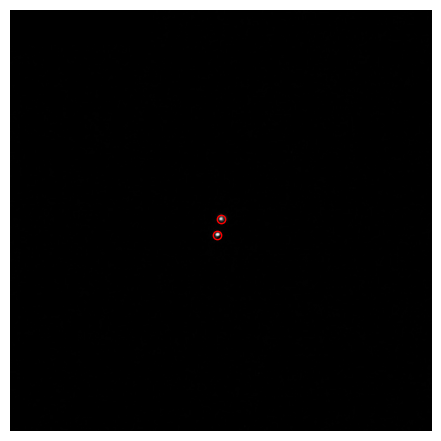


Hamal_191224_20_04
Found 6072 frames (.jpg), processing from 3036 to 5161

 :: CALCULATING SEEING ::
No stars detected in any frame for Hamal_191224_20_04 with threshold 7



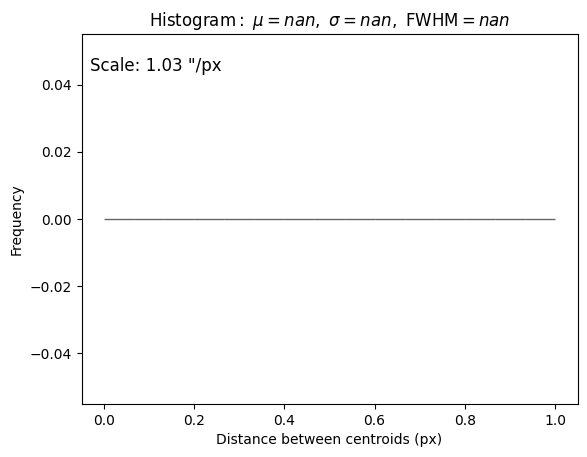

In [93]:
"""_____________________MAIN_________________________"""
folder = r"D:\Tecnicas_observacionales\Seeing\videos\Videos_Bogota_diciembre\frames\Hamal"  # <--------------- Path to frames
output_folder = r"D:\Tecnicas_observacionales\Seeing\videos\Videos_Bogota_diciembre\frames\Hamal"  # <--------Output folder


thrhld = [7]  # <------------------------Adjust this threshold value

for i, threshold_value in enumerate(thrhld):
    # Initialize lists
    results = []
    print(f"Threshold: {threshold_value}")

    output_file = os.path.join(output_folder, f"seeing_results_{threshold_value:02d}.dat")
    if os.path.exists(output_file):
        os.remove(output_file)
        print(f"Deleted existing file: {output_file}")

    files = np.sort([file for file in os.listdir(folder)])

    values = np.zeros((len(files),6), dtype=object)
    ff = -1

    for obs_idx, filename in enumerate(files):
        # Get corresponding hour angle
        h_angle = hour_angles[obs_idx % len(hour_angles)]

        # Calculate zenith correction
        sec_z = calculate_zenith_correction(h_angle, dec, lat)

        ff += 1
        plotit = True  # <------------------------------Set to False to disable frame visualization

        # Open folder containing video frames
        folder_path = f"{folder}/{filename}"
        print(f"\n{filename}")

        # Find .jpg files
        files_list = glob.glob(folder_path + r"/*.jpg")

        # Sort files numerically by frame number
        files_list.sort(key=extract_frame_number)

        # Define frames to process (skip errors at start/end)
        start = int(len(files_list)*0.5)  # <--------------- Adjust processing range
        end = int(len(files_list)*0.85)     # <--------------- Adjust processing range

        names = []
        for j in files_list:
            if folder_path in j:
                names.append(j.replace(folder_path, ""))

        if names:
            l = len(names)
            print(f"Found {l} frames (.jpg), processing from {start} to {end}")
            print("\n :: CALCULATING SEEING ::")
        else:
            print("Folder contains no .jpg files")
            continue

        distances = []
        consecutive_failures = 0  # Contador de fallos consecutivos
        stars_detected_in_file = False  # Bandera para verificar si se detectaron estrellas en algún frame

        for k in range(start, end):
            # Process each frame
            dis = identify_stars_and_distance(files_list[k], threshold_value, plotit)

            if dis == 0:  # Si no se detectaron estrellas
                consecutive_failures += 1

                if consecutive_failures >= 10:
                    break  # Salir del bucle de frames y pasar al siguiente archivo
            else:
                consecutive_failures = 0  # Reiniciar contador si se detecta una estrella
                stars_detected_in_file = True
                distances.append(dis)  
                plotit = False  # Only plot first successful detection

        if not stars_detected_in_file:  # Si no se detectaron estrellas en ningún frame del archivo
            print(f"No stars detected in any frame for {filename} with threshold {threshold_value}\n")

        distances = np.array(distances)
        no_stars = len(np.where(distances==0)[0])

        # Calculate statistics
        mu, std, sigma_sc, fuwhama, r_0, thetha = normal_distribution(distances, scale_size, lamb, Dhole, dsep, plot=plotit)

        # Apply correction
        theta_corrected = thetha * sec_z

        # Store results
        results.append({
            'filename': filename,
            'declination': decl_dms,
            'threshold': threshold_value,
            'sigma_px': std,
            'sigma_arcsec': sigma_sc,
            'r0': r_0,
            'fwhm': fuwhama,
            'theta_uncorrected': thetha,
            'hour_angle': h_angle,
            'airmass': sec_z,
            'theta_corrected': theta_corrected
        })

    # Save results to file
    with open(output_file, "w") as f:
        f.write("Filename\tdeclination\tThreshold\tSigma[px]\tSigma[arcsec]\tr0[cm]\tFWHM\tTheta_uncorrected[arcsec]\tHour_angle\tAirmass\tTheta_corrected(Seeing)[arcsec]\n")

        for r in results:
            f.write(f"{r['filename']}\t")
            f.write(f"{r['declination'][0]:+03d}d{r['declination'][1]:02d}m{r['declination'][2]:05.2f}s\t")
            f.write(f"{r['threshold']:.1f}\t{r['sigma_px']:.3f}\t")
            f.write(f"{r['sigma_arcsec']:.3f}\t{r['r0']:.3f}\t{r['fwhm']:.3f}\t")
            f.write(f"{r['theta_uncorrected']:.3f}\t")
            f.write(f"{r['hour_angle'][0]:02.0f}h{r['hour_angle'][1]:02.0f}m{r['hour_angle'][2]:05.2f}s\t")
            f.write(f"{r['airmass']:.3f}\t{r['theta_corrected']:.3f}\n")
import winsound

winsound.Beep(1000, 500)

# Analisis de threshold para DIMM

Analizaremos los archivos dat generados  para los Threshold desde 1.5 hasta 8 veces la mediana


Data combinada:
                              Filename declination  Threshold  Sigma[px]  \
0  Altair_190924_19_22_DSC_0049_Prisma  8h56m08.5s        7.0      1.044   
1  Altair_190924_19_28_DSC0050_Mascara  8h56m08.5s        7.0      1.095   
2   Altair_190924_20_24_DSC0064_Prisma  8h56m08.5s        7.0      0.881   
3  Altair_190924_20_29_DSC0065_Mascara  8h56m08.5s        7.0      0.907   
4   Altair_190924_21_28_DSC0080_Prisma  8h56m08.5s        7.0      0.830   

   Sigma[arcsec]  r0[cm]   FWHM  Theta_uncorrected[arcsec]    Hour_angle  \
0          1.169   3.481  2.458                      2.904  23h31m15.71s   
1          1.227   3.285  2.579                      3.077  23h37m16.58s   
2          0.987   4.266  2.075                      2.369  00h33m56.85s   
3          1.016   4.120  2.136                      2.453  00h38m44.55s   
4          0.930   4.578  1.956                      2.208  01h38m21.16s   

   Airmass  Theta_corrected(Seeing)[arcsec]                   source_f

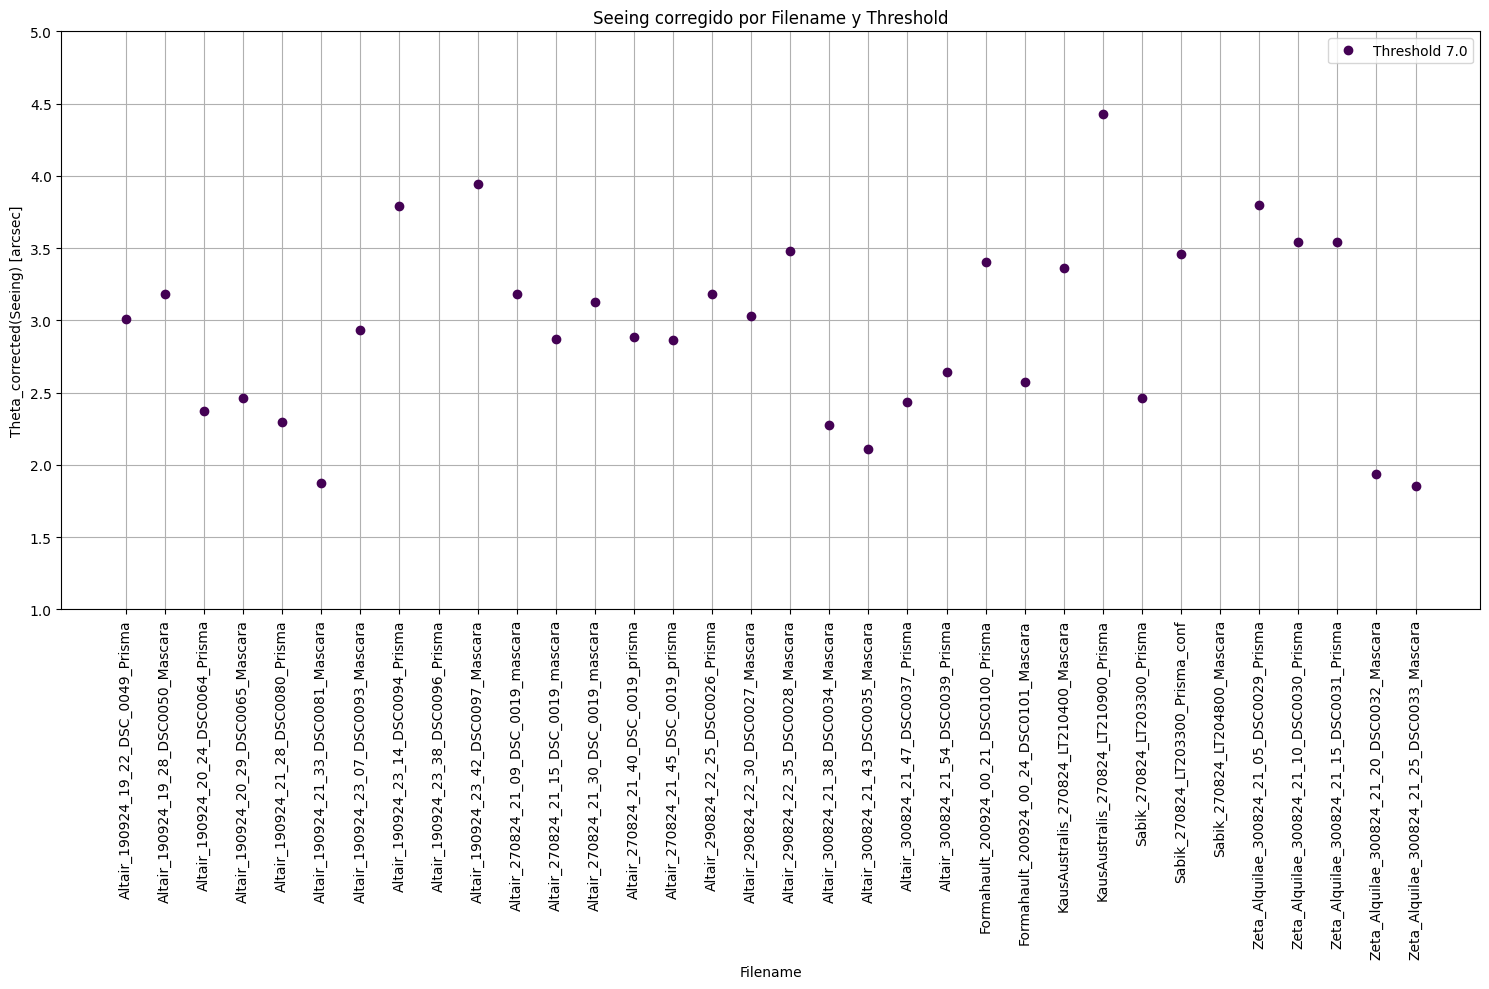

Gráfico guardado en: D:\Tecnicas_observacionales\Seeing\data\seeing_sigma_comparison_variable_files.png


In [72]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Configuración inicial
path = r"D:\Tecnicas_observacionales\Seeing\data"
output_dir = r"D:\Tecnicas_observacionales\Seeing\data"
os.makedirs(output_dir, exist_ok=True)

# Cargar todos los archivos de datos
file_pattern = os.path.join(path, "*.dat")
files = glob.glob(file_pattern)

# Leer todos los datos y combinar en un solo DataFrame
all_data = []
for file in files:
    df = pd.read_csv(file, sep="\t")
    df["source_file"] = os.path.basename(file)  # Agregar de dónde viene cada dato
    all_data.append(df)

combined_df = pd.concat(all_data, ignore_index=True)

# Verificar qué hay
print("Data combinada:")
print(combined_df.head())

# Graficar
plt.figure(figsize=(15, 10))

thresholds = sorted(combined_df["Threshold"].unique())
colors = plt.cm.viridis(np.linspace(0, 1, len(thresholds)))

for i, threshold in enumerate(thresholds):
    df_threshold = combined_df[combined_df["Threshold"] == threshold]

    # Ordenar por Filename para que las líneas tengan sentido
    df_threshold = df_threshold.sort_values("Filename")

    plt.plot(
        df_threshold["Filename"],
        df_threshold["Theta_corrected(Seeing)[arcsec]"],
        "o",  # Línea sólida con marcadores
        label=f"Threshold {threshold}",
        color=colors[i],
    )

plt.xticks(rotation=90)
plt.xlabel("Filename")
plt.ylabel("Theta_corrected(Seeing) [arcsec]")
plt.title("Seeing corregido por Filename y Threshold")
plt.ylim(1, 5)  # Ajustar el límite del eje y según sea necesario
plt.legend()
plt.grid(True)
plt.tight_layout()

# Guardar el gráfico
output_path = os.path.join(output_dir, "seeing_sigma_comparison_variable_files.png")
plt.savefig(output_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Gráfico guardado en: {output_path}")

In [ ]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter

# Configuración inicial
path = r"D:\Tecnicas_observacionales\Seeing\data\videos_diciembre"
output_dir = r"D:\Tecnicas_observacionales\Seeing\results\videos_diciembre"
os.makedirs(output_dir, exist_ok=True)

# Ver estilos disponibles y seleccionar
print("Estilos disponibles:", plt.style.available)
plt.style.use("seaborn-v0_8")  # Usar estilo moderno

# Cargar y combinar datos
file_pattern = os.path.join(path, "*_seeing_sigma.dat")
files = glob.glob(file_pattern)

all_data = []
for file in files:
    try:
        threshold = os.path.basename(file).split("_")[0]
        df = pd.read_csv(file, sep="\t")
        df["Threshold"] = float(threshold)
        all_data.append(df)
    except Exception as e:
        print(f"Error al procesar {file}: {str(e)}")

if not all_data:
    raise ValueError("No se encontraron datos válidos para graficar")

combined_df = pd.concat(all_data)
combined_df.sort_values(["Filename", "Threshold"], inplace=True)

# Preparar datos
videos = combined_df["Filename"].unique()
thresholds = sorted(combined_df["Threshold"].unique())
x = np.arange(len(videos))

# Crear figura solo para Seeing
plt.figure(figsize=(14, 8))

# Paleta de colores mejorada
colors = plt.cm.viridis(np.linspace(0, 1, len(thresholds)))

# Gráfico para Seeing sin corregir - Escala logarítmica
for i, threshold in enumerate(thresholds):
    mask = combined_df["Threshold"] == threshold
    seeing_values = combined_df.loc[mask, "Seeing_sin_corregir"].values
    plt.semilogy(
        x,
        seeing_values,
        "o-",
        linewidth=2.5,
        markersize=8,
        color=colors[i],
        label=f"Threshold {threshold}",
    )

# Configuración del gráfico
plt.xticks(x, videos, rotation=45, ha="right", fontsize=10)
plt.ylabel("Seeing sin corregir [arcsec]", fontsize=12)
plt.title(
    "Variación del Seeing sin corregir por Threshold (escala logarítmica)",
    fontsize=14,
    pad=20,
)
plt.legend(fontsize=10, framealpha=0.9, bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, which="both", ls=":", alpha=0.6)

# Ajustar márgenes para evitar cortar etiquetas
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Ajustar rectángulo de plot

# Guardar gráfico
output_path = os.path.join(output_dir, "seeing_log_scale.png")
plt.savefig(output_path, dpi=300, bbox_inches="tight")
plt.close()

print(f"Gráfico de Seeing guardado en: {output_path}")

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from datetime import datetime, timedelta

# Cargar datos
df = pd.read_csv('DIMM_data.txt', sep='\t')

# Convertir las horas a formato datetime ajustando rango
df["Hora_datetime"] = pd.to_datetime(df["Hora"], format="%H:%M")
df["Hora_datetime"] = df["Hora_datetime"].apply(lambda x: x + timedelta(days=1) if x.hour < 18 else x)

# Ordenar por hora
df = df.sort_values(by="Hora_datetime")

# Graficar con barras de error y ajustes solicitados
plt.figure(figsize=(6, 4))
plt.errorbar(
    df["Hora_datetime"],
    df["Seeing"],
    yerr=df["sigma (px) software"],
    fmt="o--",                        # Línea discontinua con marcadores
    ecolor="lightgray",               # Barras de error más claras
    capsize=3,                        # Extensión de las barras de error
    markerfacecolor="none",           # Marcadores sin relleno
    markeredgecolor="black",          # Bordes de los marcadores en negro
    color="black",                    # Línea punteada en negro
    linestyle="--"                    # Estilo de línea discontinua
    
)

# Ajustar formato del eje x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.xlim([datetime.strptime("18:00", "%H:%M"), datetime.strptime("01:00", "%H:%M") + timedelta(days=1)])
plt.ylim(0, 8.5)

# Agregar etiquetas
plt.xlabel("Hora (UTC - 5)")
plt.ylabel("Seeing (segundos de arco)")

# Agregar cuadrícula con subdivisiones
plt.grid(which="both", alpha=0.4)     # Cuadrícula principal
plt.minorticks_on()                  # Activar ticks menores
plt.grid(which="minor", alpha=0.2, linestyle=":")  # Cuadrícula secundaria con estilo punteado

# Mostrar gráfico
plt.tight_layout()
plt.show()
